
LES IMPORTS

In [1]:
import os, cv2, numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
import shutil
import hashlib
import tensorflow as tf
from tqdm import tqdm
from keras.utils import plot_model
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

# 1. PARAMS AND PATHS

In [2]:
IMG_SIZE = 150
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = 3
RANDOM_STATE = 2048
RESNET_WEIGHTS_PATH = '/kaggle/input/m/manjaka/resnet50/tensorflow2/default/1/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
DATA_DIR = "/kaggle/input/lung-cancer-types/PROJET_CHOPPER_0/lung_cancer_data"
CATEGORIES = ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']

# 2. LOAD AND PREPROCESS DATA

On earlier version, we found many duplicates. 

To remedy this, we will filter them with their hash and take them out 

In [3]:
unique_hashes = set()
data, labels = [], []

for category in CATEGORIES:
    path = os.path.join(DATA_DIR, category)
    label = CATEGORIES.index(category)
    for img_name in tqdm(os.listdir(path), desc=f"Loading {category}"):
        try:
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img_hash = hashlib.md5(img.tobytes()).hexdigest()
            if img_hash not in unique_hashes:
                unique_hashes.add(img_hash)
                data.append(img)
                labels.append(label)
        except Exception as e:
            print(f"Error: {e}")


Loading squamous_cell_carcinoma: 100%|██████████| 5000/5000 [00:57<00:00, 86.52it/s]


**SPLIT DATA**

In [4]:
data = np.array(data) / 255.0
labels = to_categorical(labels, num_classes=NUM_CLASSES)

X_temp, X_test, y_temp, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=RANDOM_STATE, stratify=labels)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp)

**Vérification des doublons**

In [5]:
import hashlib

def hash_image(img):
    return hashlib.md5(img.tobytes()).hexdigest()

train_hashes = set(hash_image(img) for img in X_train)
val_hashes = set(hash_image(img) for img in X_val)

duplicates = train_hashes.intersection(val_hashes)
print(f"Doublons entre train et val : {len(duplicates)}")



Doublons entre train et val : 0


# 3. DATA AUGMENTATION

In [6]:
datagen = ImageDataGenerator(
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.09, zoom_range=0.09, horizontal_flip=True, fill_mode='reflect'
)
train_gen = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

# 4. VISUALISATION IMAGES AUGMENTEES

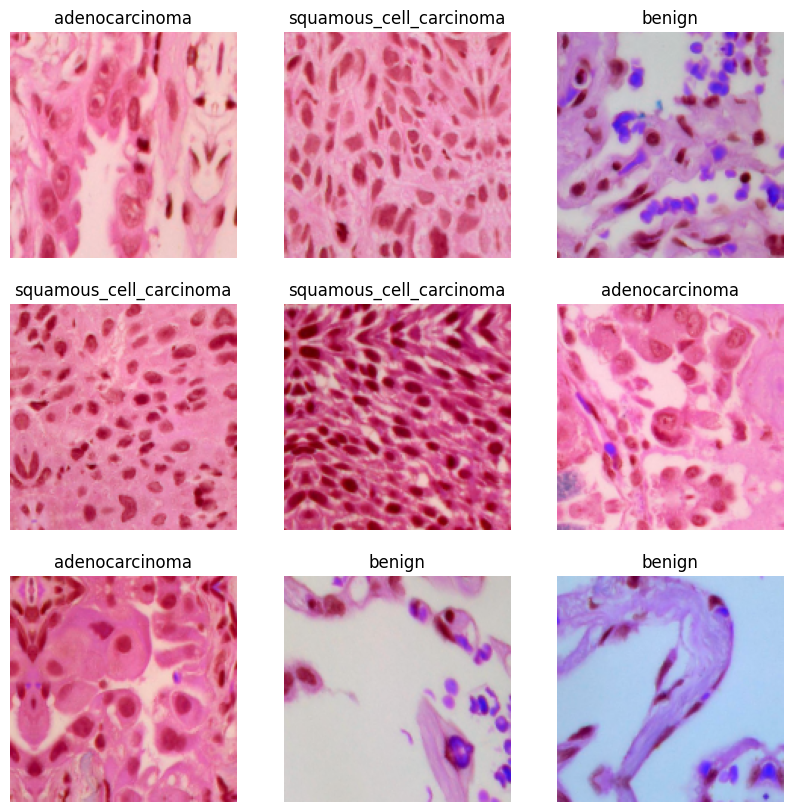

In [7]:
X_batch, y_batch = next(train_gen)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_batch[i])
    plt.axis('off')
    label_idx = np.argmax(y_batch[i])
    plt.title(CATEGORIES[label_idx])
plt.show()

In [8]:
# VERIF LABELING TRAIN
print("Exemple de correspondance :")
for i in range(3):
    print(f"Image {i} : Classe = {CATEGORIES[np.argmax(y_train[i])]}")

Exemple de correspondance :
Image 0 : Classe = adenocarcinoma
Image 1 : Classe = squamous_cell_carcinoma
Image 2 : Classe = adenocarcinoma


# 5. CONSTRUCTION DU MODELE

In [9]:
# 1. Stratégie multi-GPU
strategy = tf.distribute.MirroredStrategy()
print(f"GPU utilisés : {strategy.num_replicas_in_sync}")

with strategy.scope():
    # 2. Construction du modèle
    model = Sequential([
        ResNet50(include_top=False, pooling='max', weights=RESNET_WEIGHTS_PATH),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    
    # 3. Dégeler ResNet50 pour le fine-tuning
    model.layers[0].trainable = True

    # 4. Build model
    model.build(input_shape=(None, IMG_SIZE, IMG_SIZE, 3))
    
    # 5. Compilation (automatiquement appelée dans le scope)
    model.compile(
        optimizer='sgd',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

GPU utilisés : 2


# 6. Model SUMMARY

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 23,540,739 (89.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

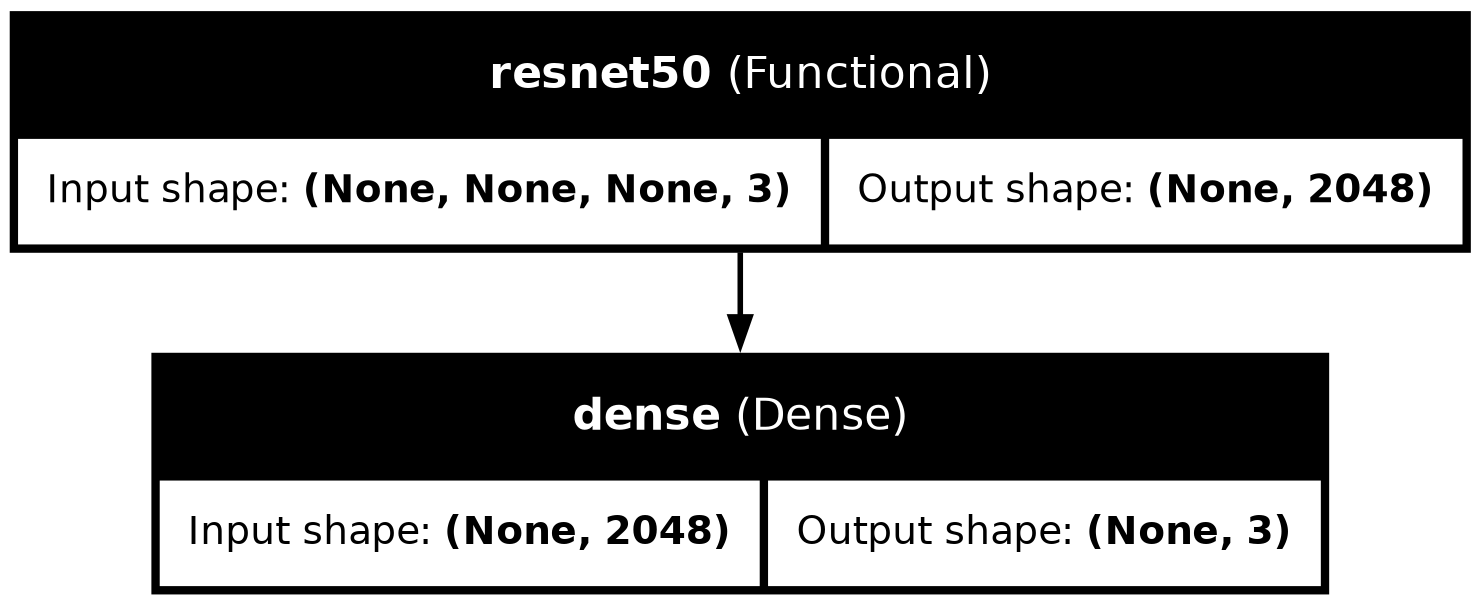

In [13]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# 7. Entrainenement du model avec early stopping

In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

history = model.fit(train_gen, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_data=(X_val, y_val),
                    callbacks=[early_stop, reduce_lr])


Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


267/267 ━━━━━━━━━━━━━━━━━━━━ 115s 248ms/step - accuracy: 0.8198 - loss: 3.1466 - val_accuracy: 0.3254 - val_loss: 1.1001 - learning_rate: 0.0100
Epoch 2/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 60s 218ms/step - accuracy: 0.8168 - loss: 1.1255 - val_accuracy: 0.3204 - val_loss: 1.1409 - learning_rate: 0.0100
Epoch 3/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 59s 218ms/step - accuracy: 0.8858 - loss: 0.3463 - val_accuracy: 0.3535 - val_loss: 1.1116 - learning_rate: 0.0100
Epoch 4/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 60s 219ms/step - accuracy: 0.9007 - loss: 0.3206 - val_accuracy: 0.8373 - val_loss: 0.3391 - learning_rate: 0.0100
Epoch 5/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 60s 220ms/step - accuracy: 0.9049 - loss: 0.4763 - val_accuracy: 0.9282 - val_loss: 0.4453 - learning_rate: 0.0100
Epoch 6/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 59s 218ms/step - accuracy: 0.9158 - loss: 0.2487 - val_accuracy: 0.9380 - val_loss: 0.1797 - learning_rate: 0.0100
Epoch 7/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 59s 218ms/step - accuracy: 0.9287 - loss

# SAVING THE MODEL

In [15]:
print(type(model))
print(model)

<class 'keras.src.models.sequential.Sequential'>
<Sequential name=sequential, built=True>


In [16]:
from datetime import datetime

# 1. Créer le dossier de sauvegarde
save_dir = "/kaggle/working/Modèle ResNet50-Cancer"
os.makedirs(save_dir, exist_ok=True)

# 2. Sauvegarde du modèle avec timestamp (pour versioning)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"resnet50_cancer_{timestamp}.h5"
model_path = os.path.join(save_dir, model_name)

# 3. Sauvegarde complète du modèle (architecture + poids)
model.save(model_path)

# 4. Copie supplémentaire dans /kaggle/working pour accès rapide
shutil.copy(model_path, "/kaggle/working/resnet50_cancer_latest.h5")

# 5. Vérification
print("Contenu du dossier de sauvegarde :")
print(os.listdir(save_dir))

Contenu du dossier de sauvegarde :
['resnet50_cancer_20250528_163309.h5']


# **8. Validation accuracy and loss**

Now let's have a look at the evolution of accuracy and loss on the same graph. Let's have also a look at the validation's.

In [17]:

def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist.get('accuracy') or hist.get('acc')
    val_acc = hist.get('val_accuracy') or hist.get('val_acc')
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))

    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()

    plt.show()


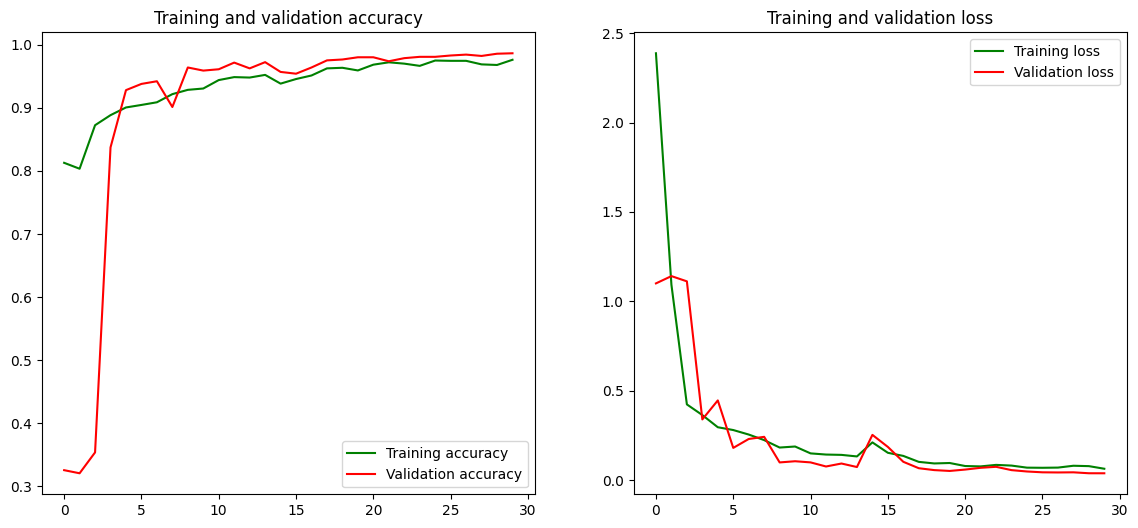

In [18]:
plot_accuracy_and_loss(history)

And a recap of our model's latest performance

In [19]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.03771568834781647
Validation accuracy: 0.9866197109222412


## <a id="54">Validation accuracy per class</a>

Let's show the validation accuracy per each class.

We start by predicting the labels for the validation set.

In [28]:
# Prédictions sur X_val (probabilités par classe)
pred_probs = model.predict(X_val)

# Prédictions finales : indice de la classe avec la plus grosse probabilité
predicted_classes = np.argmax(pred_probs, axis=1)

# Vraies classes (indices)
y_true = np.argmax(y_val, axis=1)

89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step


We create two indices, **correct** and **incorrect**, for the images in the validation set with class predicted correctly and incorrectly, respectively.

In [30]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]


We saw what is the number of correctly vs. incorrectly predicted values in the validation set.    

We show here the classification report for the validation set, with the accuracy per class and overall.

In [31]:
target_names = [f"{CATEGORIES[i]}" for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))


                         precision    recall  f1-score   support

         adenocarcinoma       0.98      0.98      0.98       945
                 benign       1.00      1.00      1.00       949
squamous_cell_carcinoma       0.98      0.98      0.98       945

               accuracy                           0.99      2839
              macro avg       0.99      0.99      0.99      2839
           weighted avg       0.99      0.99      0.99      2839



# 9. LAST PREDICTION WITH TEST SET

**Plot a sample of prediction on test set - first 25 images**

W0000 00:00:1748450460.374938     876 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "VALID" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 156 } dim { size: 156 } } } inputs { dtype: DT_FLOAT shape { dim { size: 7 } dim { size: 7 } dim { size: 3 } dim { size: 64 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12030" } environment { key: "cudnn" value: "8906" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multip

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


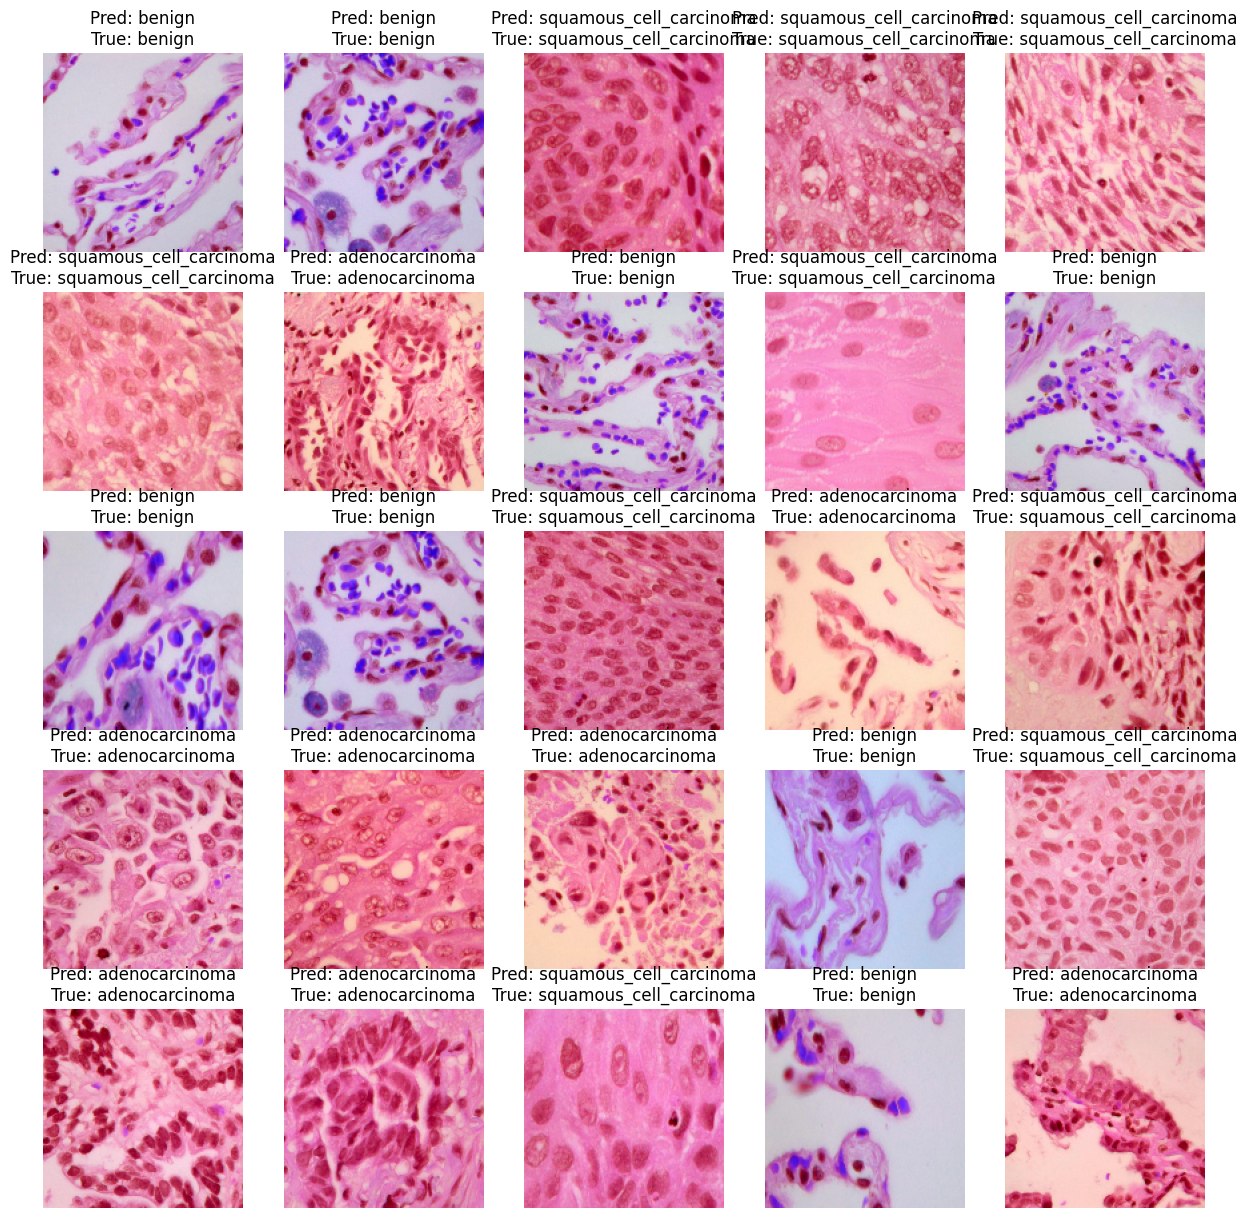

In [22]:
f, ax = plt.subplots(5, 5, figsize=(15, 15))

for i in range(25):
    img_data = X_test[i]  # image déjà normalisée (float entre 0 et 1)
    label_true = np.argmax(y_test[i])  # vraie classe

    data_input = img_data.reshape(1, IMG_SIZE, IMG_SIZE, 3)  # reshape pour modèle
    preds = model.predict(data_input)[0]
    pred_class_idx = np.argmax(preds)
    pred_class_name = CATEGORIES[pred_class_idx]

    ax[i // 5, i % 5].imshow(img_data)
    ax[i // 5, i % 5].axis('off')
    ax[i // 5, i % 5].set_title(f"Pred: {pred_class_name}\nTrue: {CATEGORIES[label_true]}")

plt.show()

**Now let's test the model on the full TEST SET**

In [24]:
pred_list = []
true_labels = []

batch_size = 32  # adapte si besoin selon ta RAM

for i in tqdm(range(0, len(X_test), batch_size)):
    batch_imgs = X_test[i:i+batch_size]
    batch_labels = y_test[i:i+batch_size]

    preds = model.predict(batch_imgs)  # shape (batch_size, 3)

    pred_list.extend(preds)
    true_labels.extend(batch_labels)

true_classes = [np.argmax(lbl) for lbl in true_labels]


  0%|          | 0/89 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


  1%|          | 1/89 [00:03<05:19,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  2%|▏         | 2/89 [00:03<02:23,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  3%|▎         | 3/89 [00:04<01:27,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


  4%|▍         | 4/89 [00:04<01:00,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


  6%|▌         | 5/89 [00:04<00:46,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


  7%|▋         | 6/89 [00:04<00:37,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


  8%|▊         | 7/89 [00:05<00:32,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


  9%|▉         | 8/89 [00:05<00:28,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 10%|█         | 9/89 [00:05<00:25,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 11%|█         | 10/89 [00:05<00:23,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 12%|█▏        | 11/89 [00:06<00:22,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 13%|█▎        | 12/89 [00:06<00:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 15%|█▍        | 13/89 [00:06<00:20,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 16%|█▌        | 14/89 [00:06<00:19,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 17%|█▋        | 15/89 [00:07<00:19,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 18%|█▊        | 16/89 [00:07<00:18,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 19%|█▉        | 17/89 [00:07<00:19,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 20%|██        | 18/89 [00:08<00:19,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 21%|██▏       | 19/89 [00:08<00:18,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 22%|██▏       | 20/89 [00:08<00:18,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 24%|██▎       | 21/89 [00:08<00:18,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 25%|██▍       | 22/89 [00:09<00:18,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 26%|██▌       | 23/89 [00:09<00:17,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 27%|██▋       | 24/89 [00:09<00:17,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 28%|██▊       | 25/89 [00:09<00:16,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 29%|██▉       | 26/89 [00:10<00:16,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 30%|███       | 27/89 [00:10<00:15,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 31%|███▏      | 28/89 [00:10<00:15,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 33%|███▎      | 29/89 [00:10<00:15,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 34%|███▎      | 30/89 [00:11<00:15,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 35%|███▍      | 31/89 [00:11<00:14,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 36%|███▌      | 32/89 [00:11<00:14,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 37%|███▋      | 33/89 [00:11<00:14,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 38%|███▊      | 34/89 [00:12<00:13,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 39%|███▉      | 35/89 [00:12<00:13,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 40%|████      | 36/89 [00:12<00:13,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 42%|████▏     | 37/89 [00:12<00:13,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 43%|████▎     | 38/89 [00:13<00:12,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 44%|████▍     | 39/89 [00:13<00:12,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 45%|████▍     | 40/89 [00:13<00:12,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 46%|████▌     | 41/89 [00:13<00:11,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 47%|████▋     | 42/89 [00:14<00:11,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 48%|████▊     | 43/89 [00:14<00:11,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 49%|████▉     | 44/89 [00:14<00:11,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 51%|█████     | 45/89 [00:14<00:11,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 52%|█████▏    | 46/89 [00:15<00:10,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 53%|█████▎    | 47/89 [00:15<00:10,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 54%|█████▍    | 48/89 [00:15<00:10,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 55%|█████▌    | 49/89 [00:15<00:10,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 56%|█████▌    | 50/89 [00:16<00:09,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 57%|█████▋    | 51/89 [00:16<00:09,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 58%|█████▊    | 52/89 [00:16<00:09,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 60%|█████▉    | 53/89 [00:16<00:08,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 61%|██████    | 54/89 [00:17<00:08,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 62%|██████▏   | 55/89 [00:17<00:08,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 63%|██████▎   | 56/89 [00:17<00:08,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 64%|██████▍   | 57/89 [00:17<00:07,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 65%|██████▌   | 58/89 [00:18<00:07,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 66%|██████▋   | 59/89 [00:18<00:07,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 67%|██████▋   | 60/89 [00:18<00:07,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 69%|██████▊   | 61/89 [00:18<00:06,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 70%|██████▉   | 62/89 [00:19<00:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 71%|███████   | 63/89 [00:19<00:06,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 72%|███████▏  | 64/89 [00:19<00:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 73%|███████▎  | 65/89 [00:19<00:06,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 74%|███████▍  | 66/89 [00:20<00:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 75%|███████▌  | 67/89 [00:20<00:05,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 76%|███████▋  | 68/89 [00:20<00:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 78%|███████▊  | 69/89 [00:20<00:04,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 79%|███████▊  | 70/89 [00:21<00:04,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 80%|███████▉  | 71/89 [00:21<00:04,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 81%|████████  | 72/89 [00:21<00:04,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 82%|████████▏ | 73/89 [00:21<00:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 83%|████████▎ | 74/89 [00:22<00:03,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 84%|████████▍ | 75/89 [00:22<00:03,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 85%|████████▌ | 76/89 [00:22<00:03,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 87%|████████▋ | 77/89 [00:22<00:02,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 88%|████████▊ | 78/89 [00:23<00:02,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 89%|████████▉ | 79/89 [00:23<00:02,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 90%|████████▉ | 80/89 [00:23<00:02,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 91%|█████████ | 81/89 [00:23<00:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 92%|█████████▏| 82/89 [00:24<00:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 93%|█████████▎| 83/89 [00:24<00:01,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 94%|█████████▍| 84/89 [00:24<00:01,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 96%|█████████▌| 85/89 [00:24<00:00,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 97%|█████████▋| 86/89 [00:25<00:00,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 98%|█████████▊| 87/89 [00:25<00:00,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 99%|█████████▉| 88/89 [00:25<00:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


100%|██████████| 89/89 [00:25<00:00,  3.44it/s]


                         precision    recall  f1-score   support

         adenocarcinoma       0.98      0.98      0.98       945
                 benign       1.00      1.00      1.00       949
squamous_cell_carcinoma       0.98      0.98      0.98       945

               accuracy                           0.99      2839
              macro avg       0.99      0.99      0.99      2839
           weighted avg       0.99      0.99      0.99      2839



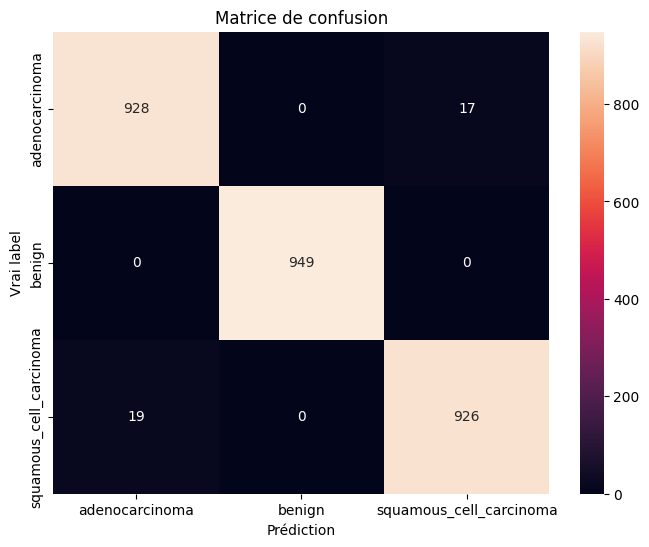

In [26]:
pred_array = np.array(pred_list)
pred_classes = np.argmax(pred_array, axis=1)
true_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(true_classes, pred_classes, target_names=CATEGORIES))

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel('Prédiction')
plt.ylabel('Vrai label')
plt.title('Matrice de confusion')
plt.show()
